## Notebook for retrieving statistical information from histograms and performing mixture modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from scipy import stats
import json

from scipy.stats import beta

In [23]:
def get_dict_from_file(file_name, data_dict, step_sizes,window=None, restriction=None,
                       batch_number=None,path='h_dict_data/'):
    """
    Reads in dictionary of H values.
    """
    if data_dict == 'h_dict' or data_dict == 'p_dict':
        with open(path+data_dict+'_w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            dictionary = file.read()
    if data_dict == 'cos_theta_dict':
        with open(path+data_dict+'_'+file_name+'_s{}'.format(max(step_sizes))+'_b{}'.format(batch_number), 'r') as file:
            dictionary = file.read()

    return json.loads(dictionary)

def optimum_components(data,n_max,plot=0):
    bics = []
    aics = []
    min_bic = 0
    min_aic = 0
    b_counter=1
    a_counter=1
    for i in np.arange(1,n_max-1): # test the AIC/BIC metric between 1 and 10 components
        gmm = GMM(n_components = i, max_iter=1000, random_state=10, covariance_type = 'full')
        labels = gmm.fit(data).predict(data)
        bic = gmm.bic(data)
        aic = gmm.aic(data)
        bics.append(bic)
        aics.append(aic)
        if bic < min_bic or min_bic == 0:
            min_bic = bic
            opt_bic = b_counter
        b_counter +=1
        if aic < min_aic or min_aic == 0:
            min_aic = aic
            opt_aic = a_counter
        a_counter +=1
    
    if plot==1:    
        fig,ax = plt.subplots(figsize=(10, 4))
        # Plot 1
        plt.plot(np.arange(1,n_max-1), bics, 'o-', lw=3, c='black', label='BIC')
        plt.plot(np.arange(1,n_max-1), aics, 'o-', lw=3, label='AIC')
        plt.legend(frameon=False, fontsize=15)
        plt.xlabel('Number of components', fontsize=12)
        plt.ylabel('Bayesian Information criterion', fontsize=12)
        plt.xticks(np.arange(0,n_max, 2))
        plt.title('Opt. components = '+str(opt_bic), fontsize=20)
        plt.show()

        
    return opt_bic,bics,opt_aic,aics

def plot_3d(dictionary, all_step_sizes, n_bins,data_variable="H",absolute=False):
    
    %matplotlib notebook
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection="3d")
    cmap = plt.cm.inferno
    
    steps = [int(s) for s in list(dictionary)]
    yticks = np.array(steps)
    
    norm_counts, bins, sample_numbers = get_hist(dictionary,n_bins,absolute=absolute)

    for i,_ in enumerate(steps):
        ytick = yticks[i]
        temp_counts = norm_counts[i]
        temp_bins = bins[i]
        xcenter = np.convolve(temp_bins, np.ones(2), "valid")/2
        xwidth = np.diff(temp_bins)
        ax.bar(left=xcenter, height=temp_counts, width=xwidth, zs=ytick,
               zdir="y", color=cmap(i/len(yticks)), alpha=0.7, edgecolor="grey", linewidth=0.3)

    ax.set_xlabel("{}".format(data_variable))
    ax.set_ylabel("downsampling step size")
    ax.set_zlabel("p({})".format(data_variable))

    ax.set_yticks(yticks)
    plt.show()
    
    return norm_counts, bins,sample_numbers

def get_hist(dictionary, nbins,absolute=False):
    """
    """
    keys_list = list(dictionary)
    
    counts_all = np.empty((len(keys_list), nbins))
    bins_all = np.empty((len(keys_list), nbins+1))
    sample_number_all = np.empty((len(keys_list), 1))
    
    if absolute==False:
    
        for i,key in enumerate(keys_list):
            data = dictionary[key]
            sample_number = len(data)
            counts, bins = np.histogram(data, nbins, density=True)  # normalised so area under histogram is 1
            sample_number_all[i]= sample_number
            counts_all[i] = counts
            bins_all[i] = bins
    else:
        
        for i,key in enumerate(keys_list):
            data = dictionary[key]
            sample_number = len(data)
            counts, bins = np.histogram([abs(x) for x in data], nbins, density=True)  # normalised so area under histogram is 1
            sample_number_all[i]= sample_number
            counts_all[i] = counts
            bins_all[i] = bins

    return counts_all, bins_all,sample_number_all

In [24]:
filenames = np.array(['Control_frame001-200',
                      'Control_frame200-400',
                      'Control_frame400-600',
                      'Control_frame600-800',
                      'Control_frame800-1000',
                      'Control_frame1000-1200',
                      'LanB1_frame001-200',
                      'LanB1_frame200-400',
                      'LanB1_frame400-600',
                      'LanB1_frame600-800',
                      'LanB1_frame800-1000',
                      'LanB1_frame1000-1200',
                      'defLanB1_300817_frame200-400',
                      'defLanB1_300817_frame400-600'])

In [4]:
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
cos_theta_dict = get_dict_from_file(filenames[0],'cos_theta',step_sizes,batch_number=1,path='haemocyte_cos_theta_data/')

<IPython.core.display.Javascript object>


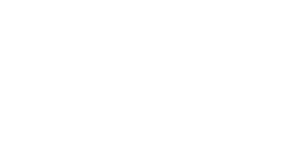

In [5]:
norm_counts, bins,sample_numbers = plot_3d(cos_theta_dict,step_sizes,20,absolute=False,data_variable="cos({})".format(r'$\theta$'))

In [6]:
def get_hist_mids(bins):
    
    return 0.5*(bins[1:] + bins[:-1])

def get_hist_probs(counts,bins,biased=False):
    
    if biased==False:
        probs = counts / (np.sum(counts)-1)
    else:
        probs = counts/np.sum(counts)
        
    return probs

def get_hist_mean(probs,mids):
    
    return np.sum(mids*probs)

def get_hist_sd(probs,mids,mean):
    
    x_2 = np.sum((mids**2)*probs)
    
    return np.sqrt(x_2 - mean**2)

def get_hist_skew(probs,mids,mean,sd):
    
    return np.sum(((mids-mean)/sd)**3)

def return_stats(counts, bins):
    
    hist_probs = get_hist_probs(counts,bins)
    hist_mids = get_hist_mids(bins)
    hist_mean = get_hist_mean(hist_probs,hist_mids)
    hist_sd = get_hist_sd(hist_probs,hist_mids,hist_mean)
    hist_skew = get_hist_skew(hist_probs,hist_mids,hist_mean,hist_sd)
    
    return hist_mean,hist_sd,hist_skew
    
    

In [7]:
def get_stats_dict(total_counts,total_bins,sample_numbers,pandas_df=True):
    stats_dict = {}
    stats_dict['samples'] = np.empty(len(total_counts))
    stats_dict['mean'] = np.empty(len(total_counts))
    stats_dict['sd'] = np.empty(len(total_counts))
    stats_dict['skew'] = np.empty(len(total_counts))
    
    for i in np.arange(len(total_counts)):
        mean,sd,skew = return_stats(total_counts[i],total_bins[i])
        stats_dict['samples'][i] = sample_numbers[i]
        stats_dict['mean'][i] = mean
        stats_dict['sd'][i] = sd
        stats_dict['skew'][i] = skew 
        
    if not pandas_df:
        return stats_dict
    
    else:
        column_labels = np.arange(1,len(total_counts)+1)
        df = pd.DataFrame.from_dict(stats_dict, orient='index', columns=column_labels)
        return df.apply(pd.to_numeric, downcast='integer')
        

In [8]:
stats_dict = get_stats_dict(norm_counts,bins,sample_numbers)
#stats_dict['mean'].values
sample_numbers = stats_dict.iloc[0,:].values
mean_values = stats_dict.iloc[1,:].values
sd_values = stats_dict.iloc[2,:].values
skew_values = stats_dict.iloc[3,:].values

In [9]:
stats_dict

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
samples,574.000000,1148.000000,1722.000000,2296.000000,2870.000000,3444.000000,4018.000000,4592.000000,5166.000000,5740.000000,6314.000000,6888.000000,7462.000000,8036.000000,8610.000000
mean,0.401112,0.422461,0.450160,0.480104,0.501062,0.528249,0.547623,0.564015,0.580922,0.587223,0.594697,0.601768,0.607957,0.608238,0.608935
sd,0.256625,0.266024,0.275941,0.286879,0.299124,0.304528,0.307542,0.316639,0.327497,0.339229,0.352001,0.366514,0.380173,0.398994,0.415742
skew,-40.154731,-100.317980,-95.313667,-175.626662,-151.560150,-247.489580,-239.450655,-243.531535,-364.756487,-267.556509,-298.176261,-281.860408,-301.669277,-261.838658,-231.647220


<IPython.core.display.Javascript object>


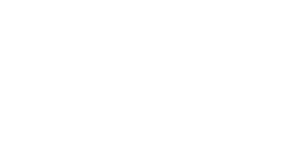

<ErrorbarContainer object of 3 artists>

In [10]:
fig,ax = plt.subplots(figsize=(8,8))
ax.errorbar(x=step_sizes,y=skew_values,yerr=sd_values/np.sqrt(sample_numbers))

In [11]:
def plot_hist_2d(file_name, all_step_sizes, step_sizes_plot, nbins,batch_number):
    """
    """
    dictionary = get_dict_from_file(file_name, 'cos_theta', step_sizes, window=None, restriction=None,
                       batch_number=batch_number,path='haemocyte_cos_theta_data/')
    
    cmap = plt.cm.plasma
    
    for s in step_sizes_plot:
        plt.hist(dictionary[str(s)], nbins, density=True, histtype='step', label='step size {}'.format(s),
                 color=cmap((s-1)/len(all_step_sizes)))
    plt.legend(loc='upper left')
    plt.xlabel('H')
    plt.ylabel('p(H)')
    plt.title(file_name)

    
def subplot_hist_2d(file_name, all_step_sizes, step_sizes_plot,  nbins,batch_number, pos):
    """
    """
    i, j = pos
    
    dictionary = get_dict_from_file(file_name, 'cos_theta', step_sizes, window=None, restriction=None,
                 batch_number=batch_number,path='haemocyte_cos_theta_data/')
    
    cmap = plt.cm.plasma
    
    for s in step_sizes_plot:
        ax[i,j].hist(dictionary[str(s)], nbins, density=True, histtype='step', label='step size {}'.format(s),
                color=cmap((s-1)/len(all_step_sizes)))
    ax[i,j].legend(loc='upper left')
    ax[i,j].set_xlabel('cos({})'.format(r'$\theta$'))
    ax[i,j].set_ylabel('p(cos({}))'.format(r'$\theta$'))
    ax[i,j].set_title(file_name)

In [12]:
def six_panel_plot(step_sizes,plot_ss,nbins,haemocyte_type,filenames,batch_number):

    fig, ax = plt.subplots(2, 3, figsize=(10, 12),constrained_layout=True)

    fig.suptitle(haemocyte_type, fontsize=16)

    subplot_hist_2d(filenames[0], step_sizes, plot_ss, nbins,batch_number, [0,0])
    subplot_hist_2d(filenames[1], step_sizes, plot_ss, nbins,batch_number, [0,1])
    subplot_hist_2d(filenames[2], step_sizes, plot_ss, nbins,batch_number, [0,2])
    subplot_hist_2d(filenames[3], step_sizes, plot_ss, nbins,batch_number, [1,0])
    subplot_hist_2d(filenames[4], step_sizes, plot_ss, nbins,batch_number, [1,1])
    subplot_hist_2d(filenames[5], step_sizes, plot_ss, nbins,batch_number, [1,2])
    
    plt.show()
    
    

In [13]:
filenames_control = np.array(['Control_frame001-200', 'Control_frame200-400', 'Control_frame400-600', 'Control_frame600-800',
                              'Control_frame800-1000', 'Control_frame1000-1200'])
filenames_mutant = np.array(['LanB1_frame001-200', 'LanB1_frame200-400', 'LanB1_frame400-600', 'LanB1_frame600-800',
                             'LanB1_frame800-1000', 'LanB1_frame1000-1200'])
filenames_defmutant = np.array(['defLanB1_300817_frame200-400', 'defLanB1_300817_frame400-600'])

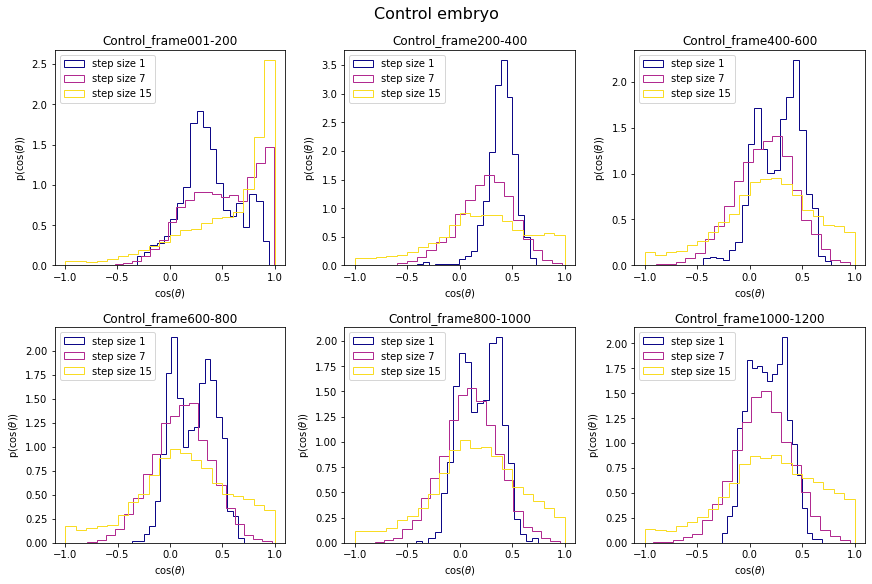

In [14]:
# Control embryo 2D histogram plots
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#step_sizes= [1,2,3,4,5,6,7,8]
plot_ss = [1,7,15]
#plot_ss = [1,4,8]
nbins = 20
batch_number = 1

fig, ax = plt.subplots(2, 3, figsize=(12, 8),constrained_layout=True)

fig.suptitle("Control embryo", fontsize=16)

subplot_hist_2d(filenames_control[0], step_sizes, plot_ss, nbins,batch_number, [0,0])
subplot_hist_2d(filenames_control[1], step_sizes, plot_ss, nbins,batch_number, [0,1])
subplot_hist_2d(filenames_control[2], step_sizes, plot_ss, nbins,batch_number, [0,2])
subplot_hist_2d(filenames_control[3], step_sizes, plot_ss, nbins,batch_number, [1,0])
subplot_hist_2d(filenames_control[4], step_sizes, plot_ss, nbins,batch_number, [1,1])
subplot_hist_2d(filenames_control[5], step_sizes, plot_ss, nbins,batch_number, [1,2])

#step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#six_panel_plot(step_sizes,[1,7,15],20,'Control Embryo',filenames_control,1)
plt.savefig("costheta_time_plots/cos_theta_hist_s{}_b{}".format( max(step_sizes), batch_number), dpi=300,facecolor='white')

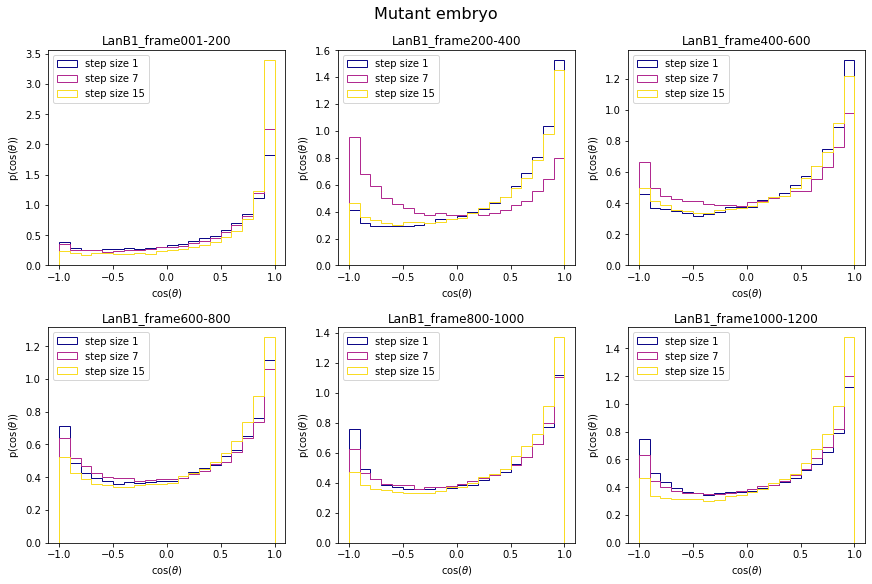

In [16]:
%matplotlib inline
step_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#step_sizes= [1,2,3,4,5,6,7,8]
plot_ss = [1,7,15]
#plot_ss = [1,4,8]
nbins = 20
batch_number = 2

fig, ax = plt.subplots(2, 3, figsize=(12, 8),constrained_layout=True)

fig.suptitle("Mutant embryo", fontsize=16)

subplot_hist_2d(filenames_mutant[0], step_sizes, plot_ss, nbins,batch_number, [0,0])
subplot_hist_2d(filenames_mutant[1], step_sizes, plot_ss, nbins,batch_number, [0,1])
subplot_hist_2d(filenames_mutant[2], step_sizes, plot_ss, nbins,batch_number, [0,2])
subplot_hist_2d(filenames_mutant[3], step_sizes, plot_ss, nbins,batch_number, [1,0])
subplot_hist_2d(filenames_mutant[4], step_sizes, plot_ss, nbins,batch_number, [1,1])
subplot_hist_2d(filenames_mutant[5], step_sizes, plot_ss, nbins,batch_number, [1,2])


<IPython.core.display.Javascript object>


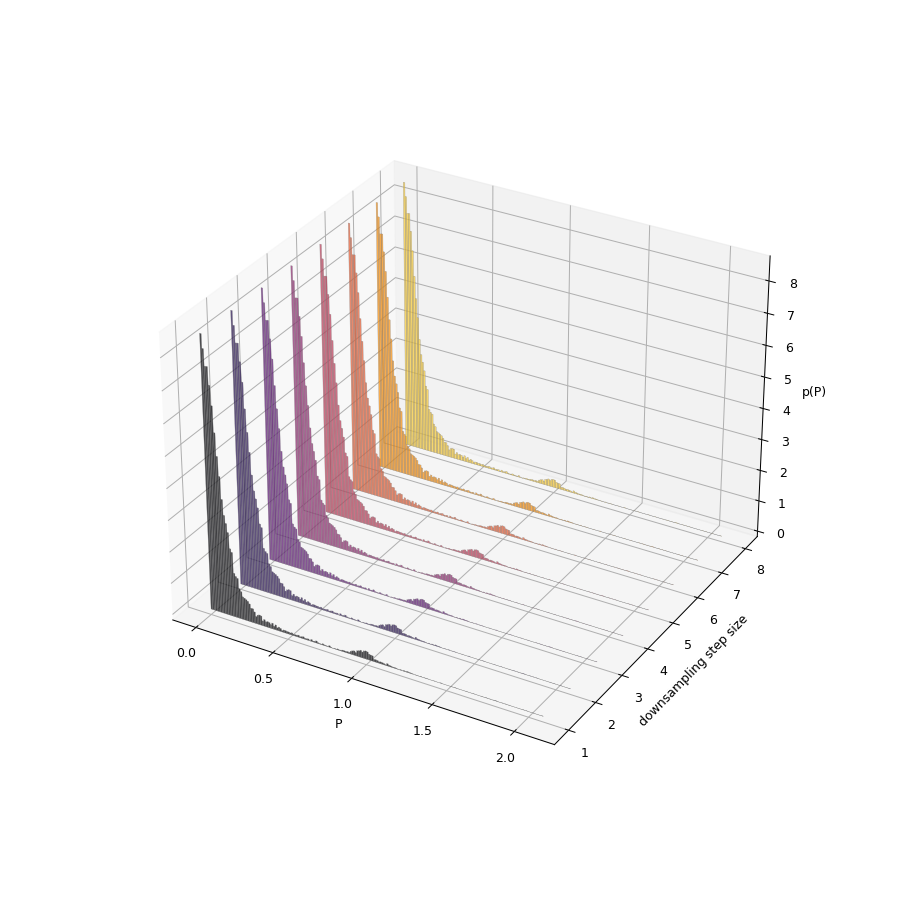

True

In [40]:
p_dict = get_dict_from_file(filenames[8], 'p_dict', np.arange(1,9),window=20, restriction=10000, path='p_data/')
plot_3d(p_dict, np.arange(1,9), 200,data_variable="P",absolute=False)
p_dict['5']==p_dict['3']

### Scrap code

def get_dict_from_file(file_name, window, step_sizes, restriction,
                       path='h_dict_data/',full_file_name=None):
    """
    Reads in dictionary of H values.
    """
    try:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name, 'r') as file:
            h_dict = file.read()
    except FileNotFoundError:
        with open(path+'h_dict_'+'w{}_'.format(window)+'s{}_'.format(max(step_sizes))+'r{}_'.format(restriction)+file_name+'.txt', 'r') as file:
            h_dict = file.read()
        
    return json.loads(h_dict)


<IPython.core.display.Javascript object>


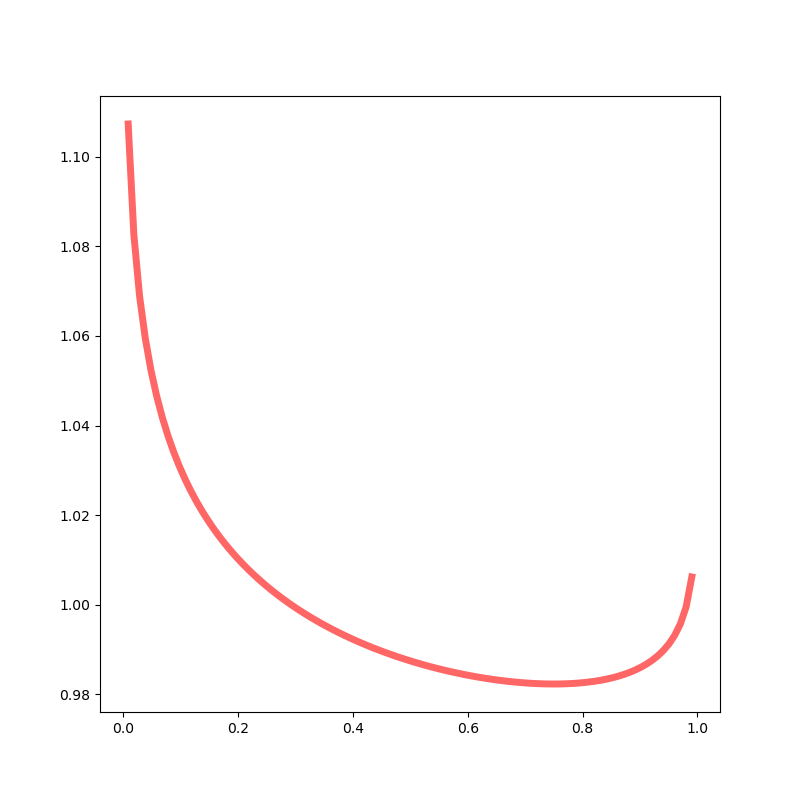

In [97]:
a, b = 0.97,.99
fig,ax = plt.subplots(figsize=(8,8))
x = np.linspace(beta.ppf(0.01, a, b),
                beta.ppf(0.99, a, b), 100)
ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')